# 数据处理： 常量计算

## 1. 准备

In [172]:
import numpy as np
import scipy.optimize as opt
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import stats

# params_fixed
a = 0.15        # 翼展 (m)
d = 0.028       # 翼宽 (m)
m = 0.002183    # 质量 (kg)
I = (5/24) * 0.002183 * (0.15)**2  # 转动惯量
omega = 10.0    # 固定角速度 (rad/s)
rho = 1.225     # 空气密度 (kg/m^3)
g = 9.793        # 重力加速度 (m/s²)

# fixed
prm = rho * a * d / (2 * m)

# 定义原公式 - 待修改
def formula(ax, ay, az, v, vx, vy, vz):
    def equation(var):
        [D, CL, CD] = var
        # f1, f2, f3 = 0 即得原公式
        f1 = ax - D * rho * CL * omega * v * (a**4) * vy / (2*I) + prm* CD * v * vx
        f2 = ay + prm * v * vy * (CL - CD)
        f3 = az - prm * v * vz * (CL - CD) + g
        return [f1, f2, f3]
    return equation    

## 2. 原始数据读取

In [ ]:
dt = {
    'names':   ('t','x','y','z'), 
    'formats': (float, float, float, float)
}
p_raw = np.loadtxt('ps.csv',
                delimiter=',',
                skiprows=1,
                dtype=dt)[3:] # 舍去开始两个点

## 3. 降噪处理

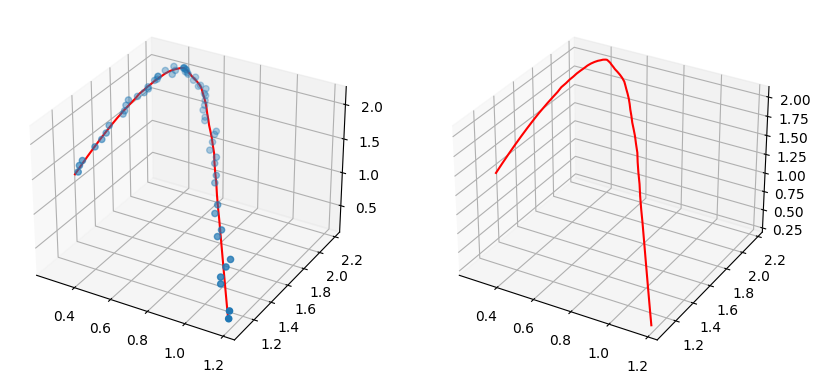

In [171]:
p = np.array(p_raw)
p['t'] = p_raw['t']
p['x'] = savgol_filter(p_raw['x'], window_length=16, polyorder=3)
p['y'] = savgol_filter(p_raw['y'], window_length=16, polyorder=3)
p['z'] = savgol_filter(p_raw['z'], window_length=16, polyorder=3)

# 展示降噪结果
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(121, projection='3d')
ax2 = plt.subplot(122, projection='3d')

ax1.scatter(p_raw['x'], p_raw['y'], p_raw['z'], 'b-')
ax1.plot(p['x'], p['y'],p['z'], 'r-')
ax2.plot(p['x'], p['y'],p['z'], 'r-')

plt.show()

## 4. 取值求方差

In [179]:
# 直接计算每个时刻的瞬时速度、加速度
v_x = np.gradient(p['x'], p['t'])
v_y = np.gradient(p['y'], p['t'])
v_z = np.gradient(p['z'], p['t'])
v = (v_x**2 + v_y ** 2 + v_z ** 2) ** 0.5

a_x = np.gradient(v_x, p['t'])
a_y = np.gradient(v_y, p['t'])
a_z = np.gradient(v_z, p['t'])

# 求解 - 暂定
solves = []
for i in range(len(a_x)):
    equation = formula(a_x[i], a_y[i], a_z[i], v[i], v_x[i], v_y[i], v_z[i])
    solves.append(opt.least_squares(equation, [1, 1, 1]))
solves = np.array(list(map(lambda x:x.x, solves)))

# 原始数据展示
print("\t\tD\t\tCL\t\tCD\t")
print("原始数据平均", np.average(solves, axis=0))
print("原始数据方差", np.var(solves, axis=0))

# 四分位距取值
[D, CL, CD] = np.hsplit(solves,3)
D_z = np.abs(stats.zscore(D))
CL_z = np.abs(stats.zscore(CL))
CD_z = np.abs(stats.zscore(CD))
data = [D[(D_z < 3)], CL[(CL_z < 3)], CD[(CD_z < 3)]]
print("取值数据平均", np.average(data[0]),np.average(data[1]),np.average(data[2]))
print("取值数据方差", np.var(data[0]),np.var(data[1]), np.var(data[2]))






		D		CL		CD	
原始数据平均 [ 0.18194447  0.69834187 -0.20117475]
原始数据方差 [0.40568777 2.78671578 4.5681228 ]
取值数据平均 0.11217983685832032 0.4510871248696194 0.09952357238971205
取值数据方差 0.11555592211953163 0.9101356030412745 1.8825049078995575
